# PDF Text Extraction and Analysis - Batch Processing for Sample-1a

## Setting Input and Output Directories
This notebook processes multiple PDF documents from the sample-1a dataset to extract text and structure. The next cell sets up the input PDF directory path and the corresponding JSON output directory to build a larger dataset.

In [67]:
import os
import glob

# Define the input and output directories
pdf_dir = "../hackathon-task/sample-1a/Datasets/Pdfs/"
json_dir = "../hackathon-task/sample-1a/Datasets/Output.json/"

# Get list of all PDF files in the directory
pdf_files = glob.glob(os.path.join(pdf_dir, "*.pdf"))

# Get list of all JSON files in the directory
json_files = glob.glob(os.path.join(json_dir, "*.json"))

# Map PDFs to their corresponding JSON files (if available)
pdf_to_json = {}
for pdf_path in pdf_files:
    pdf_basename = os.path.basename(pdf_path).split('.')[0]
    json_path = os.path.join(json_dir, f"{pdf_basename}.json")
    
    # Only include PDFs that have corresponding JSON files
    if os.path.exists(json_path):
        pdf_to_json[pdf_path] = json_path

print(f"Found {len(pdf_files)} PDF files in the directory.")
print(f"Found {len(json_files)} JSON files in the directory.")
print(f"Processing {len(pdf_to_json)} PDFs with matching JSON files.")

Found 7 PDF files in the directory.
Found 5 JSON files in the directory.
Processing 5 PDFs with matching JSON files.


# Text Extraction Using MultiProcessing
The code below imports the custom `extract` module to extract text from the PDF file. It uses multiprocessing to efficiently extract text snippets from all pages and retrieves the page dimensions which will be needed for feature engineering later.

# Batch Processing Function
Let's create a function that processes a single PDF file and its corresponding JSON output file from the sample-1a dataset. This function will encapsulate all the processing steps from the original notebook so we can easily apply them to multiple files.

In [68]:
import extract
import pandas as pd
import json
import re
from collections import Counter
from thefuzz import fuzz
import os

def process_pdf_file(pdf_path, json_path):
    """Process a single PDF file and its corresponding JSON file
    
    Args:
        pdf_path: Path to the PDF file
        json_path: Path to the corresponding JSON file with ground truth
        output_csv_dir: Directory to save the output CSV
        
    Returns:
        DataFrame containing the labeled text lines
    """
    print(f"Processing: {os.path.basename(pdf_path)}")
    
    # Initialize the extractor
    extractor = extract.TextExtractor(pdf_path)
    texts = extractor.extract_text_from_all_pages_multiprocessing()
    
    # Get page dimensions
    dims = extractor.get_page_dimensions(0)
    PAGE_WIDTH = dims["width"]
    PAGE_HEIGHT = dims["height"]
    
    # Sort text snippets
    sorted_snippets = sorted(texts, key=lambda s: (s['page'], s['y_position'], s['bbox'][0]))
    
    # Group snippets into lines and process them
    def group_snippets_into_lines(snippets, y_tolerance=2.0):
        if not snippets:
            return []
            
        lines = []
        current_line_snippets = [snippets[0]]
        
        for i in range(1, len(snippets)):
            prev_snippet = snippets[i-1]
            current_snippet = snippets[i]
            
            if (current_snippet['page'] == prev_snippet['page'] and 
                abs(current_snippet['y_position'] - prev_snippet['y_position']) < y_tolerance):
                current_line_snippets.append(current_snippet)
            else:
                lines.append(current_line_snippets)
                current_line_snippets = [current_snippet]
                
        lines.append(current_line_snippets)
        return lines

    def process_lines(grouped_lines):
        processed_lines = []
        for line_snippets in grouped_lines:
            line_snippets.sort(key=lambda s: s['bbox'][0])
            
            full_text = "".join(s['text'] for s in line_snippets).strip()
            if not full_text:
                continue
                
            import re
            
            toc_pattern = re.compile(r'^(.*?)\.{3,}\s*\d+$')
            match = toc_pattern.match(full_text)
            if match:
                full_text = match.group(1).strip()
            
            elif full_text.endswith('...') and full_text.count('.') > 3:
                full_text = full_text.rstrip('.')

            x0 = min(s['bbox'][0] for s in line_snippets)
            y0 = min(s['bbox'][1] for s in line_snippets)
            x1 = max(s['bbox'][2] for s in line_snippets)
            y1 = max(s['bbox'][3] for s in line_snippets)
            
            avg_font_size = sum(s['font_size'] for s in line_snippets) / len(line_snippets)
            
            processed_lines.append({
                "text": full_text,
                "page": line_snippets[0]['page'],
                "avg_font_size": avg_font_size,
                "y_position": line_snippets[0]['y_position'],
                "bbox": (x0, y0, x1, y1),
                "font_name": line_snippets[0]['font_name'],
                "source_pdf": os.path.basename(pdf_path)
            })
        return processed_lines

    grouped_lines = group_snippets_into_lines(sorted_snippets)
    final_lines = process_lines(grouped_lines)
    
    # Get document statistics
    def get_doc_stats(lines):
        font_sizes = [round(l['avg_font_size'], 2) for l in lines if l['text']]
        if not font_sizes:
            return {'modal_font_size': 10.0}
            
        modal_font_size = Counter(font_sizes).most_common(1)[0][0]
        return {
            'modal_font_size': modal_font_size
        }
    
    document_stats = get_doc_stats(final_lines)
    
    # Engineer features
    def engineer_features(lines, doc_stats):
        modal_font_size = doc_stats['modal_font_size']
        
        for i, line in enumerate(lines):
            font_name_lower = line['font_name'].lower()
            line['is_bold'] = any(indicator in font_name_lower for indicator in ['bold', 'black', 'heavy', 'sembold'])

            line['is_all_caps'] = line['text'].isupper() and len(line['text']) > 3
            
            line['text_len'] = len(line['text'])

            numbering_pattern = re.compile(
                r'^\s*(?:(?:Chapter|Section)\s+[\w\d]+|'
                r'\d{1,2}(?:\.\d{1,2})*\.?|'
                r'[A-Z]\.|'
                r'\([a-z]\)|'
                r'[ivx]+\.)'
            )
            line['starts_with_numbering'] = bool(numbering_pattern.match(line['text']))

            if modal_font_size > 0:
                line['relative_font_size'] = line['avg_font_size'] / modal_font_size
            else:
                line['relative_font_size'] = 1.0

            line['norm_y_pos'] = line['y_position'] / PAGE_HEIGHT

            line_center = (line['bbox'][0] + line['bbox'][2]) / 2
            page_center = PAGE_WIDTH / 2
            line['is_centered'] = abs(line_center - page_center) < (0.1 * PAGE_WIDTH)

            space_before = -1
            space_after = -1
            
            if i > 0 and lines[i-1]['page'] == line['page']:
                prev_line_bottom = lines[i-1]['bbox'][3]
                current_line_top = line['bbox'][1]
                space_before = current_line_top - prev_line_bottom
                
            if i < len(lines) - 1 and lines[i+1]['page'] == line['page']:
                current_line_bottom = line['bbox'][3]
                next_line_top = lines[i+1]['bbox'][1]
                space_after = next_line_top - current_line_bottom

            line['space_before'] = space_before
            line['space_after'] = space_after
            
        return lines
    
    featured_lines = engineer_features(final_lines, document_stats)
    
    # Label dataset
    def normalize_text(text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = text.strip()
        text = re.sub(r'[\u2013\u2014]', '-', text)
        text = re.sub(r'\s+', ' ', text)
        return text

    def create_labeled_dataset_final(featured_lines, ground_truth_headings, ground_truth_title, fuzz_threshold=85):
        gt_headings_by_page = {}
        for h in ground_truth_headings:
            page = h['page']
            if page not in gt_headings_by_page:
                gt_headings_by_page[page] = []
            gt_headings_by_page[page].append({
                'level': h['level'],
                'norm_text': normalize_text(h['text'])
            })
        
        page_1_lines = [line for line in featured_lines if line['page'] == 1]
        if page_1_lines:
            title_candidate = max(page_1_lines, key=lambda l: l['relative_font_size'])
            
            norm_gt_title = normalize_text(ground_truth_title)
            
            title_text_to_check = normalize_text(title_candidate['text'])
            candidate_index = featured_lines.index(title_candidate)
            if candidate_index + 1 < len(featured_lines):
                next_line = featured_lines[candidate_index+1]
                if abs(next_line['avg_font_size'] - title_candidate['avg_font_size']) < 1:
                     title_text_to_check += " " + normalize_text(next_line['text'])

            if fuzz.partial_ratio(title_text_to_check, norm_gt_title) > fuzz_threshold:
                title_candidate['label'] = 'Title'
                if " " in title_text_to_check:
                     featured_lines[candidate_index+1]['label'] = 'Title'
                
        for line in featured_lines:
            if 'label' in line:
                continue
                
            line['label'] = 'Body Text'
            page_num = line['page']
            
            if page_num in gt_headings_by_page:
                norm_line_text = normalize_text(line['text'])
                
                best_match = max(
                    gt_headings_by_page[page_num],
                    key=lambda h: fuzz.ratio(norm_line_text, h['norm_text']),
                    default=None
                )
                
                if best_match:
                    score = fuzz.ratio(norm_line_text, best_match['norm_text'])
                    if score > fuzz_threshold:
                        line['label'] = best_match['level']
                        
        return featured_lines
    
    # Load ground truth data
    with open(json_path, 'r', encoding='utf-8') as f:
        out = json.load(f)
    
    # Correct page numbering
    corrected_outline = [{**h, 'page': h['page'] + 1} for h in out['outline']]
    
    # Create labeled dataset
    labeled_lines = create_labeled_dataset_final(featured_lines, corrected_outline, out['title'])
    
    # Fix page numbers to be 0-indexed
    for line in labeled_lines:
        line['page'] -= 1
    
    # Convert to DataFrame
    df = pd.DataFrame(labeled_lines)
        
    return df

# Executing Batch Processing
Now that we've created our function to process individual PDF files, let's create an output directory for our labeled data and then process all the PDF files with matching JSON files in batch.

In [69]:
# Create output directory for labeled data CSVs

# Process all PDF files with matching JSON files
all_dataframes = []

for pdf_path, json_path in pdf_to_json.items():
    try:
        df = process_pdf_file(pdf_path, json_path)
        all_dataframes.append(df)
    except Exception as e:
        print(f"Error processing {pdf_path}: {str(e)}")

print(f"Successfully processed {len(all_dataframes)} PDF files.")

Processing: E0CCG5S239.pdf
Processing: E0H1CM114.pdf
Processing: E0CCG5S312.pdf
Processing: STEMPathwaysFlyer.pdf
Processing: TOPJUMP-PARTY-INVITATION-20161003-V01.pdf
Successfully processed 5 PDF files.


# Combining All Data into a Single Dataset
Let's combine all the individual labeled datasets into one large dataset, which will be useful for training machine learning models. We'll concatenate all the DataFrames and save the result to a single CSV file.

In [70]:
# Combine all DataFrames into a single dataset
if all_dataframes:
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    print(f"Combined dataset created with {len(combined_df)} rows")
    
    # Display statistics about the combined dataset
    label_counts = combined_df['label'].value_counts()
    print("\nLabel distribution in the combined dataset:")
    print(label_counts)
    
    pdf_counts = combined_df['source_pdf'].value_counts()
    print("\nNumber of rows from each PDF:")
    print(pdf_counts)
else:
    print("No data to combine. Please check that PDF processing was successful.")

Combined dataset created with 937 rows

Label distribution in the combined dataset:
label
Body Text    871
H3            26
H2            20
H1            12
Title          4
H4             4
Name: count, dtype: int64

Number of rows from each PDF:
source_pdf
E0H1CM114.pdf                                488
E0CCG5S312.pdf                               283
STEMPathwaysFlyer.pdf                        109
E0CCG5S239.pdf                                45
TOPJUMP-PARTY-INVITATION-20161003-V01.pdf     12
Name: count, dtype: int64


# Finalizing the Dataset
Let's finalize our dataset by renaming the combined dataset for clarity and generating additional statistics.

In [71]:
# We'll use the dataframes we've already created
if all_dataframes:
    # This is already our final DataFrame
    final_df = combined_df
    
    # Save to CSV with a different name to distinguish it
    final_csv_path = os.path.join("final_dataset.csv")
    final_df.to_csv(final_csv_path, index=False)
    
    print(f"Created final dataset with {len(final_df)} rows from {len(all_dataframes)} PDFs")
    print(f"Saved to {final_csv_path}")
    
    # Display dataset statistics
    print("\nFinal Dataset Statistics:")
    print(f"Total rows: {len(final_df)}")
    print(f"Unique PDFs: {final_df['source_pdf'].nunique()}")
    print("\nLabel distribution:")
    print(final_df['label'].value_counts())
    
    # Create a summary table by PDF source
    pdf_summary = final_df.groupby('source_pdf')['label'].value_counts().unstack().fillna(0)
    print("\nRows by PDF and label type:")
    print(pdf_summary)
else:
    print("No data to combine.")

Created final dataset with 937 rows from 5 PDFs
Saved to final_dataset.csv

Final Dataset Statistics:
Total rows: 937
Unique PDFs: 5

Label distribution:
label
Body Text    871
H3            26
H2            20
H1            12
Title          4
H4             4
Name: count, dtype: int64

Rows by PDF and label type:
label                                      Body Text   H1    H2    H3   H4  \
source_pdf                                                                   
E0CCG5S239.pdf                                  43.0  0.0   0.0   0.0  0.0   
E0CCG5S312.pdf                                 263.0  8.0  10.0   0.0  0.0   
E0H1CM114.pdf                                  449.0  2.0   8.0  25.0  4.0   
STEMPathwaysFlyer.pdf                          105.0  1.0   2.0   1.0  0.0   
TOPJUMP-PARTY-INVITATION-20161003-V01.pdf       11.0  1.0   0.0   0.0  0.0   

label                                      Title  
source_pdf                                        
E0CCG5S239.pdf                    

Import required libraries for Model Training and Evaluation

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

Feature selection

In [73]:
features = [
    'page',
    'avg_font_size',
    'y_position',
    'font_name',
    'is_bold',
    'is_all_caps',
    'text_len',
    'starts_with_numbering',
    'relative_font_size',
    'norm_y_pos',
    'is_centered',
    'space_before',
    'space_after'
]

target = 'label'

# Create the feature matrix (X) and target vector (y)
X = final_df[features].copy()
y = final_df[target]

 A Random Forest can't handle string-based categorical features directly.
 We need to convert the 'font_name' column into numerical format.
 LabelEncoder assigns a unique integer to each unique font name.


In [74]:
print("--- Unique Labels Found in Dataset ---")
print(final_df['label'].unique())
print("-" * 30)


--- Unique Labels Found in Dataset ---
['Title' 'Body Text' 'H1' 'H2' 'H3' 'H4']
------------------------------


In [75]:
font_encoder = LabelEncoder()
X['font_name'] = font_encoder.fit_transform(X['font_name'])

# The target labels (H1, H2, etc.) also need to be encoded.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# We can see the mapping of encoded labels to original labels
# This is useful for interpreting the results later.
print("--- Target Label Encoding ---")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"'{class_name}' -> {i}")
print("-" * 30)


--- Target Label Encoding ---
'Body Text' -> 0
'H1' -> 1
'H2' -> 2
'H3' -> 3
'H4' -> 4
'Title' -> 5
------------------------------


Split Data into Training and Testing Sets

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=10101, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("-" * 30)

Training set size: 749 samples
Testing set size: 188 samples
------------------------------


Train the Random Forest Model

In [77]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=123,
    class_weight='balanced',
    oob_score=True, # Out-of-bag score to estimate generalization accuracy
    n_jobs=-1 # Use all available CPU cores
)

print("Training the Random Forest model...")
rf_classifier.fit(X_train, y_train)
print("Model training complete.")
print("-" * 30)


Training the Random Forest model...
Model training complete.
------------------------------


Evaluate Model Performance

--- Classification Report ---
              precision    recall  f1-score   support

   Body Text       0.97      1.00      0.99       175
          H1       1.00      1.00      1.00         2
          H2       1.00      0.75      0.86         4
          H3       1.00      0.60      0.75         5
          H4       0.00      0.00      0.00         1
       Title       0.00      0.00      0.00         1

    accuracy                           0.97       188
   macro avg       0.66      0.56      0.60       188
weighted avg       0.96      0.97      0.97       188

------------------------------
Overall Model Accuracy: 0.9734
Out-of-Bag (OOB) Score: 0.9626
------------------------------
--- Confusion Matrix ---


/home/a7x/projects/adobe-hack/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/a7x/projects/adobe-hack/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/a7x/projects/adobe-hack/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

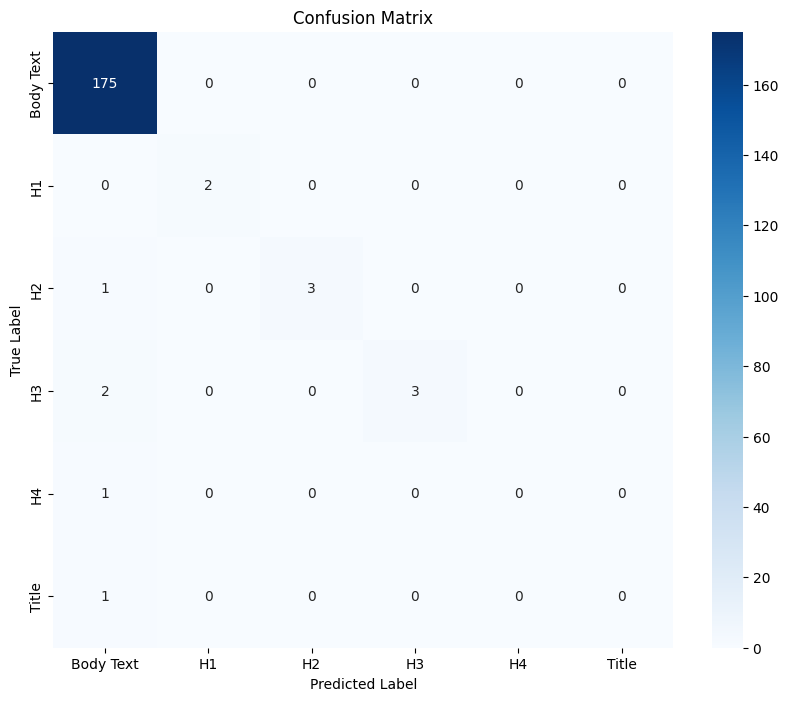

--- Feature Importances ---
                  Feature  Importance
8      relative_font_size    0.140579
12            space_after    0.135825
1           avg_font_size    0.132376
11           space_before    0.105726
3               font_name    0.103993
6                text_len    0.080048
9              norm_y_pos    0.078119
0                    page    0.070799
4                 is_bold    0.061326
2              y_position    0.061245
10            is_centered    0.018097
7   starts_with_numbering    0.011524
5             is_all_caps    0.000343


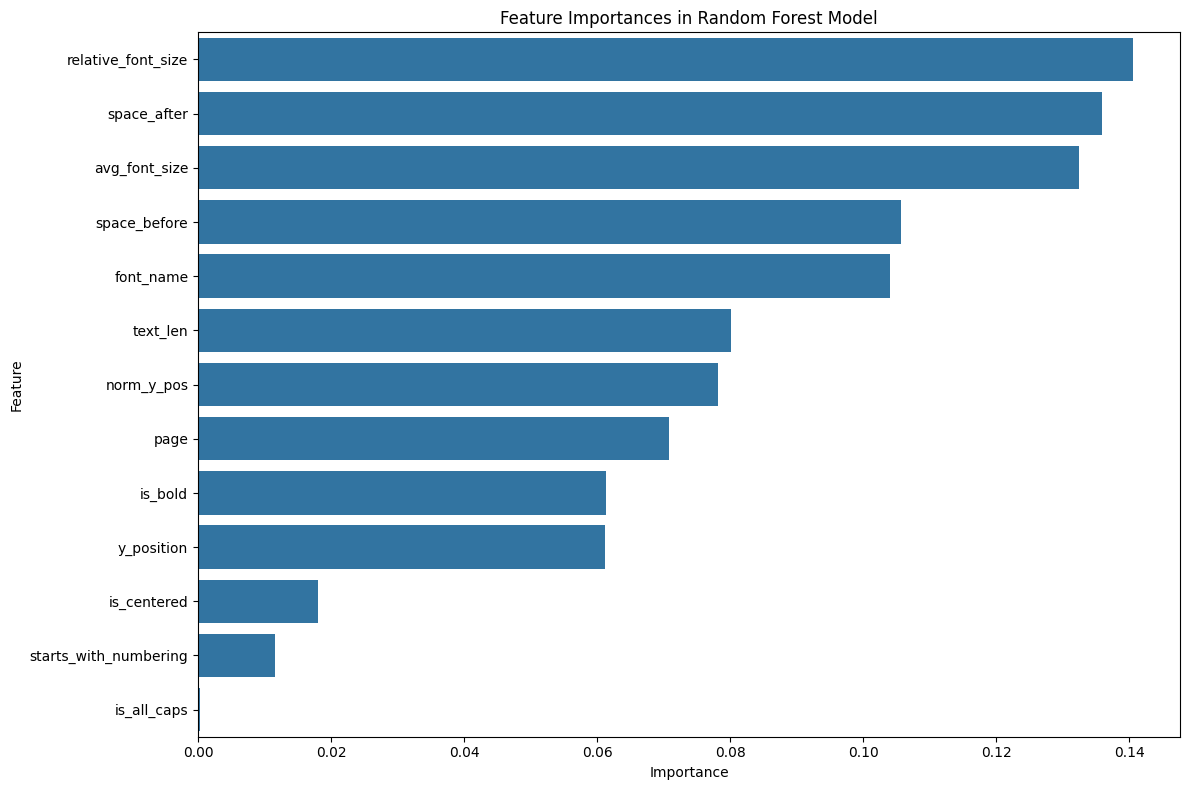

In [78]:
y_pred = rf_classifier.predict(X_test)

# Decode the predictions and true labels to get the original string labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# --- Classification Report ---
# This report shows the main classification metrics: precision, recall, and f1-score for each class.
# This is exactly what the hackathon scoring criteria mentions.
print("--- Classification Report ---")
print(classification_report(y_test_labels, y_pred_labels))
print("-" * 30)


# --- Accuracy Score ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {accuracy:.4f}")
print(f"Out-of-Bag (OOB) Score: {rf_classifier.oob_score_:.4f}")
print("-" * 30)


# --- Confusion Matrix ---
# A confusion matrix gives a detailed breakdown of which classes are being confused with others.
print("--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- 7. Feature Importance ---
# Random Forest can tell us which features were most influential in making predictions.
print("--- Feature Importances ---")
importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

In [ ]:
# run the model using entire dataset as test set

y_pred_full = rf_classifier.predict(X)
y_pred_labels_full = label_encoder.inverse_transform(y_pred_full)
# check if the predictions are correct
correct_predictions = (y_pred_labels_full == final_df[target].values)
accuracy_full = correct_predictions.mean()
print(f"Accuracy on full dataset: {accuracy_full:.4f}")
print("-" * 30)